<a href="https://colab.research.google.com/github/ayoubbensakhria/finance_algo/blob/master/FXPROBOT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Ta-Lib

In [ ]:
!pip install yfinance --user

In [16]:
import requests
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
import yfinance as yf
from termcolor import colored as cl
from datetime import date, timedelta
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from matplotlib import pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (20, 10)
plt.style.use('fivethirtyeight')

# Data Extraction

,Time,Open,High,Low,Close,Volume
Time,,,,,,
2010-01-01 00:00:00,2010-01-01 00:00:00,1.432840,1.432940,1.432265,1.432840,5.721000e+08
2010-01-01 00:30:00,2010-01-01 00:30:00,1.432825,1.432985,1.432340,1.432785,5.253000e+08
2010-01-01 01:00:00,2010-01-01 01:00:00,1.432885,1.432955,1.432090,1.432870,5.663000e+08
2010-01-01 01:30:00,2010-01-01 01:30:00,1.432735,1.433035,1.432135,1.432655,4.402000e+08
2010-01-01 02:00:00,2010-01-01 02:00:00,1.432900,1.433030,1.432295,1.432860,5.386000e+08


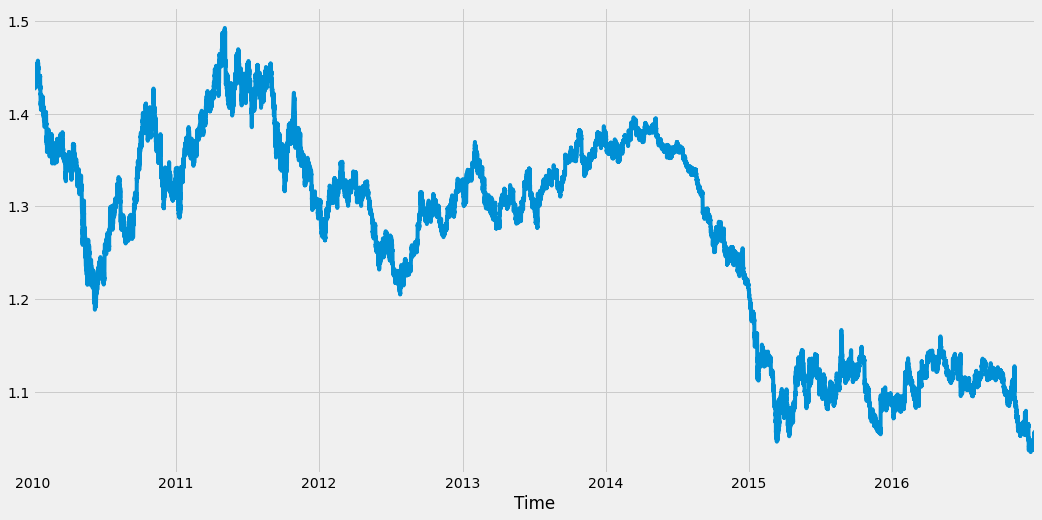

In [6]:
#read data
df = pd.read_csv('/content/drive/MyDrive/data/eurusd30.csv', parse_dates=True)
# #setting index as date because some statsmodels might not work
df.index = pd.to_datetime(df['Time'])
#plot
df['Close'].plot(figsize=(16,8))
df.head()

# Add RSI, MACD, CCI MA indicators to df

In [ ]:
def get_macd(df, slow, fast, smooth):
    exp1 = df['Close'].ewm(span = fast, adjust = False).mean()
    exp2 = df['Close'].ewm(span = slow, adjust = False).mean()
    exp1_8 = df['Close'].ewm(span = fast*8, adjust = False).mean()
    exp2_8 = df['Close'].ewm(span = slow*8, adjust = False).mean()
    # 30Mn MACD
    df['macd'] = pd.DataFrame(exp1 - exp2)
    df['signal']  = pd.DataFrame(df['macd'].ewm(span = smooth, adjust = False).mean())
    df['hist'] = pd.DataFrame(df['macd'] - df['signal'])
    # 4Hour MACD
    df['macd8'] = pd.DataFrame(exp1_8 - exp2_8)
    df['signal8']  = pd.DataFrame(df['macd8'].ewm(span = smooth, adjust = False).mean())
    df['hist8'] = pd.DataFrame(df['macd8'] - df['signal8'])
    return df

macd = get_macd(df.tail(10000), 26, 12, 9)
macd.tail()

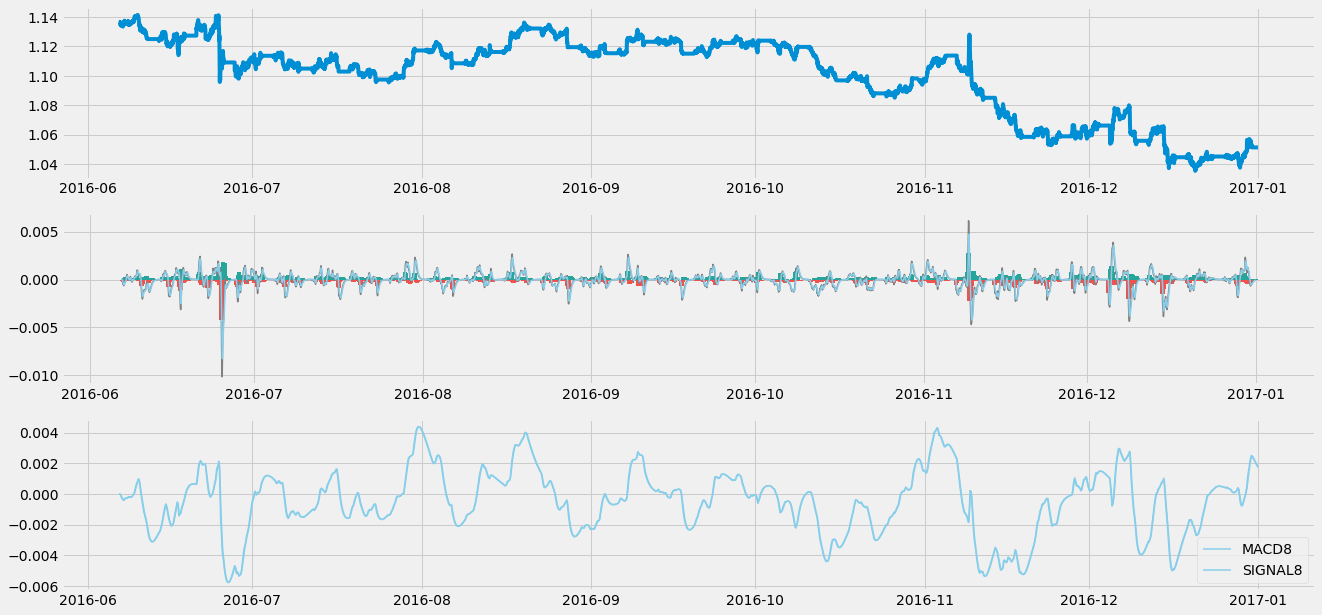

In [47]:
# Plot MACD
def plot_macd(prices, df):
    ax1 = plt.subplot2grid((3,1), (0,0),  colspan = 1)
    ax2 = plt.subplot2grid((3,1), (1,0), colspan = 1)
    ax3 = plt.subplot2grid((3,1), (2,0), colspan = 1)

    ax1.plot(prices)
    ax2.plot(df['macd'], color = 'grey', linewidth = 1.5, label = 'MACD')
    ax2.plot(df['signal'], color = 'skyblue', linewidth = 1.5, label = 'SIGNAL')
    ax3.plot(df['macd8'], color = 'black', linewidth = 1.5, label = 'MACD8')
    ax3.plot(df['signal8'], color = 'blue', linewidth = 1.5, label = 'SIGNAL8')

    for i in range(len(prices)):
        if str(df['hist'][i])[0] == '-':
            ax2.bar(prices.index[i], df['hist'][i], color = '#ef5350')
        else:
            ax2.bar(prices.index[i], df['hist'][i], color = '#26a69a')

    plt.legend(loc = 'lower right')

plot_macd(macd['Close'], macd)